In [215]:
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 
import numpy as np

In [339]:
pip install tensorflow==2.12.0


ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1)
ERROR: No matching distribution found for tensorflow==2.12.0

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [66]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 40

In [17]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 2152 files belonging to 3 classes.


In [18]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [24]:
len(dataset)

68

In [26]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 2 1 2 0 1 0 1 0 0 2 0 0 1 0]


2024-07-05 13:07:30.764803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[176. 174. 185.]
  [177. 175. 186.]
  [177. 175. 186.]
  ...
  [154. 156. 169.]
  [152. 154. 167.]
  [146. 148. 161.]]

 [[177. 175. 186.]
  [177. 175. 186.]
  [176. 174. 185.]
  ...
  [155. 157. 170.]
  [153. 155. 168.]
  [148. 150. 163.]]

 [[178. 176. 187.]
  [177. 175. 186.]
  [175. 173. 184.]
  ...
  [154. 156. 169.]
  [154. 156. 169.]
  [150. 152. 165.]]

 ...

 [[122. 119. 126.]
  [122. 119. 126.]
  [135. 132. 139.]
  ...
  [133. 131. 142.]
  [128. 126. 137.]
  [132. 130. 141.]]

 [[137. 134. 141.]
  [154. 151. 158.]
  [137. 134. 141.]
  ...
  [134. 132. 143.]
  [131. 129. 140.]
  [130. 128. 139.]]

 [[138. 135. 142.]
  [139. 136. 143.]
  [155. 152. 159.]
  ...
  [134. 132. 143.]
  [135. 133. 144.]
  [133. 131. 142.]]]


2024-07-05 13:13:25.306954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-07-05 13:23:52.024020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


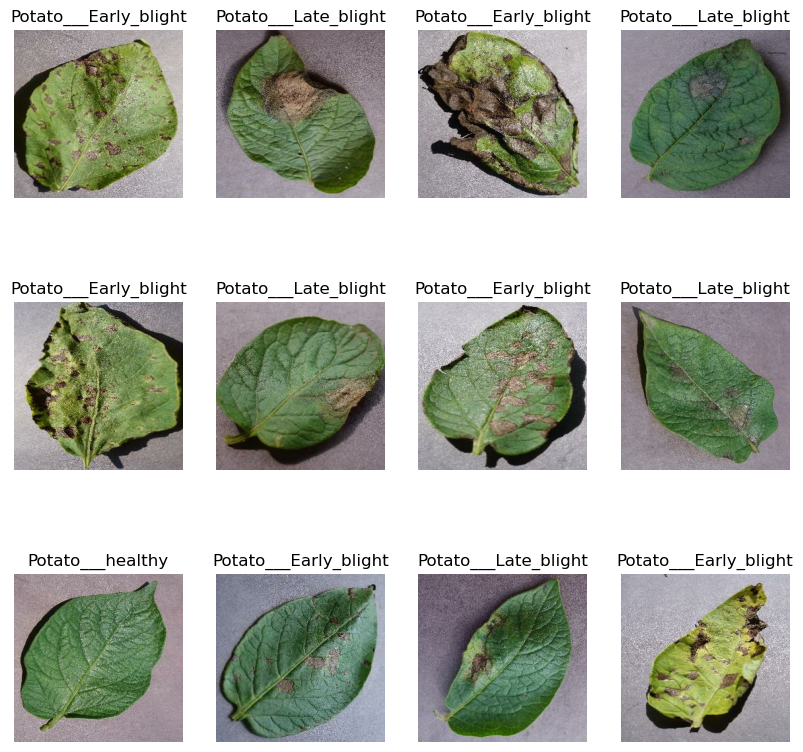

In [64]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
   

In [68]:
len(dataset)

68

## Now we are going to split the data for traning, validation and testing (80%, 10%, 10%)

In [72]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [74]:
train_ds = dataset.take(54)
len(train_ds)

54

In [76]:
VTdata = dataset.skip(54) 
len(VTdata)

14

In [78]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [80]:
val_ds = VTdata.take(6)
len(val_ds)

6

In [82]:
test_ds = VTdata.skip(6)
len(test_ds)

8

In [96]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle =True, shuffle_size = 10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split *ds_size)
    val_size = int(val_split *ds_size)

    trian_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [98]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [112]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [114]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 


In [133]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.16.2


In [135]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)

])

In [139]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [157]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, BATCH_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation= 'relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (2,2), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (2,2), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation ='softmax')
])
model.build(input_shape=input_shape)

In [159]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (256, 256, 256, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (256, 256, 256, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (256, 254, 254, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (256, 127, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (256, 126, 126, 64)    │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (256, 63, 63, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (256, 62, 62, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (256, 31, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (256, 29, 29, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (256, 14, 14, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (256, 12, 12, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (256, 6, 6, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (256, 2304)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (256, 64)              │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (256, 3)               │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,171 (965.51 KB)

 Trainable params: 247,171 (965.51 KB)

 Non-trainable params: 0 (0.00 B)

In [165]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
               
               )

In [167]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.4927 - loss: 0.9275 - val_accuracy: 0.6310 - val_loss: 0.8312
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7858 - loss: 0.5704 - val_accuracy: 0.7917 - val_loss: 0.5116
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8461 - loss: 0.3792 - val_accuracy: 0.8155 - val_loss: 0.4240
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8485 - loss: 0.3683 - val_accuracy: 0.7976 - val_loss: 0.4853
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8899 - loss: 0.2693 - val_accuracy: 0.9167 - val_loss: 0.2739
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9282 - loss: 0.2204 - val_accuracy: 0.9643 - val_loss: 0.1162
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8911 - loss: 0.2513 - val_accuracy: 0.9345 - val_loss: 0.1844
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9531 - loss: 0.1366 - val_accuracy: 0.9345 - val_loss:

In [169]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.8400 - loss: 0.8715


In [171]:
scores

[0.842411458492279, 0.8203125]

In [173]:
history 

In [175]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [177]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [187]:
history.history['accuracy']

[0.5416666865348816,
 0.8130787014961243,
 0.8356481194496155,
 0.8587962985038757,
 0.8935185074806213,
 0.9293981194496155,
 0.9108796119689941,
 0.9403935074806213,
 0.9432870149612427,
 0.9560185074806213,
 0.953125,
 0.9554398059844971,
 0.9618055820465088,
 0.9629629850387573,
 0.9554398059844971,
 0.9658564925193787,
 0.9785879850387573,
 0.9664351940155029,
 0.9623842835426331,
 0.9722222089767456,
 0.9780092835426331,
 0.9774305820465088,
 0.9710648059844971,
 0.9699074029922485,
 0.9722222089767456,
 0.9774305820465088,
 0.9722222089767456,
 0.9855324029922485,
 0.9670138955116272,
 0.9756944179534912,
 0.9814814925193787,
 0.9814814925193787,
 0.9832175970077515,
 0.9826388955116272,
 0.9704861044883728,
 0.9797453880310059,
 0.9670138955116272,
 0.9924768805503845,
 0.9884259104728699,
 0.9861111044883728,
 0.9866898059844971,
 0.9884259104728699,
 0.9710648059844971,
 0.9924768805503845,
 0.9971064925193787,
 0.9947916865348816,
 0.9930555820465088,
 0.9936342835426331,
 0

In [189]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Traning and validation loss')

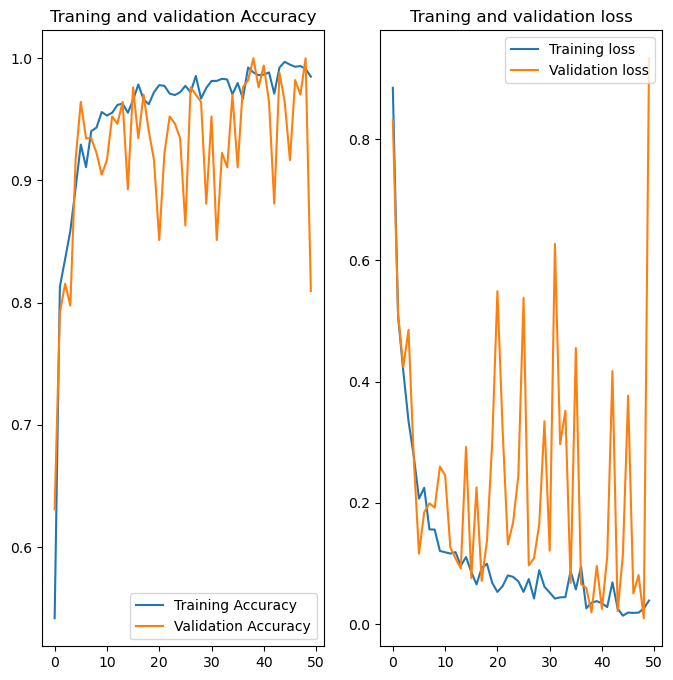

In [193]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title("Traning and validation Accuracy")


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = "Training loss")
plt.plot(range(EPOCHS), val_loss, label="Validation loss")
plt.legend(loc='upper right')
plt.title("Traning and validation loss")


first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
predicted label: Potato___Early_blight


2024-07-06 11:41:48.785600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


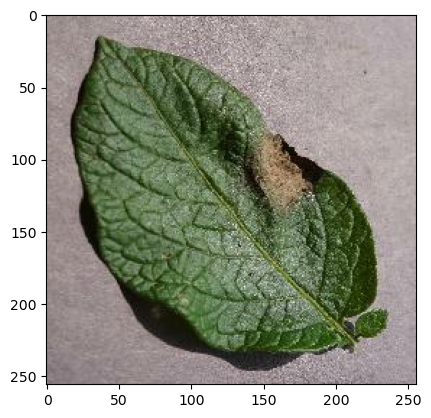

In [293]:
for image_batch, label_batch in dataset.take(1):

    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [281]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) 

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 *(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-07-05 23:33:31.664412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


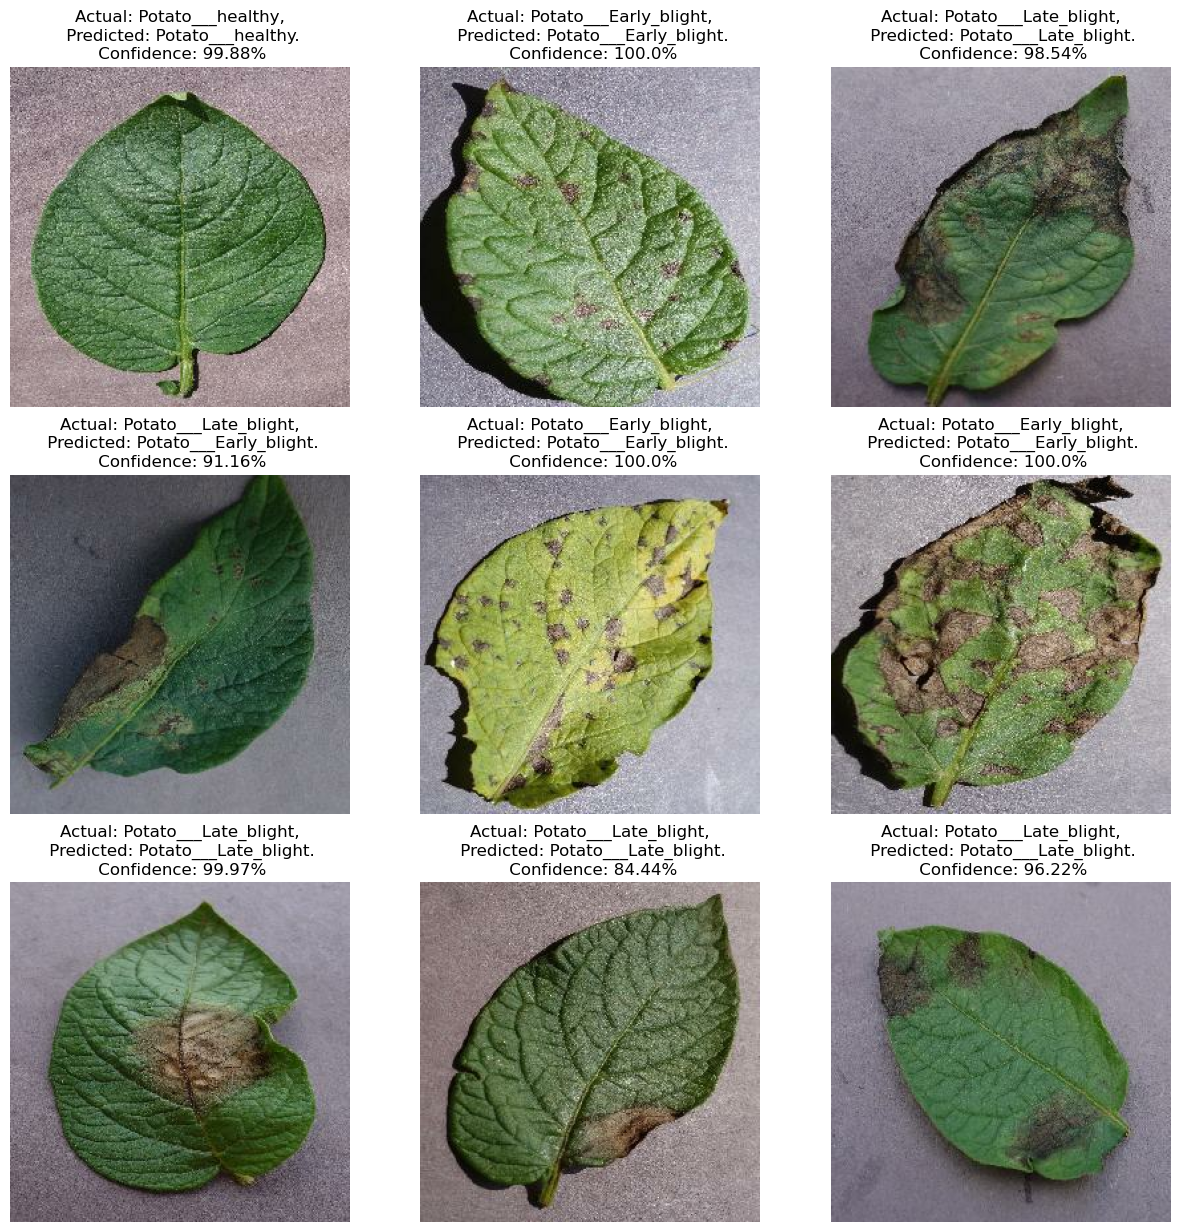

In [283]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')

## Saving the model in tf 

In [317]:
model_version = 1
model.export(f"../models/model_{model_version}")

INFO:tensorflow:Assets written to: ../models/model_1/assets


INFO:tensorflow:Assets written to: ../models/model_1/assets


Saved artifact at '../models/model_1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5092734928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5092736464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060514192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060515536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060515728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060516496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060516112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060516880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060514960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060516688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060514768: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

In [319]:
model.save(f"../models/model_{model_version}.keras")

In [321]:

loaded_model = tf.saved_model.load(f"../models/model_{model_version}")

In [327]:
import os

def get_next_version(base_path):
    # Get all items in the directory
    items = os.listdir(base_path)
    
    # Filter for directories that match the pattern "model_XX"
    existing_models = [item for item in items if os.path.isdir(os.path.join(base_path, item)) and item.startswith("model_")]
    
    # Extract version numbers
    version_numbers = [int(model.split("_")[1]) for model in existing_models if model.split("_")[1].isdigit()]
    
    # Determine the next version number
    if version_numbers:
        next_version = max(version_numbers) + 1
    else:
        next_version = 1
    
    # Format the version number as a two-digit string
    return f"{next_version:02d}"

# Set the base path for models
base_path = "../models"

# Get the next version number
model_version = get_next_version(base_path)

# Export the model with the new version number
model.export(f"{base_path}/model_{model_version}")

print(f"Model exported as model_{model_version}")

INFO:tensorflow:Assets written to: ../models/model_02/assets


INFO:tensorflow:Assets written to: ../models/model_02/assets


Saved artifact at '../models/model_02'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5092734928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5092736464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060514192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060515536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060515728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060516496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060516112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060516880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060514960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060516688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5060514768: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [343]:
print(tf.__version__)


2.16.2


In [347]:
import tensorflow as tf

# Load the existing model
model = tf.keras.models.load_model("../models/model_02", custom_objects=None, compile=True)

# Save the model in H5 format
model.save("../models/model_02.h5")
print("Model converted and saved as H5 format successfully")


ValueError: File format not supported: filepath=../models/model_02. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(../models/model_02, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [ ]:
from io import BytesIO
import tensorflow as tf
import numpy as np
import uvicorn
from PIL import Image
from fastapi import FastAPI, File, UploadFile
from tensorflow.keras.models import load_model

app = FastAPI()

MODEL = load_model("../models/model_02")
CLASS_NAME = ["Early Blight", "Late Blight", "Healthy"]


@app.get("/ping")
async def ping():
    return "Hello, I am alive"


def read_file_as_image(data) -> np.ndarray:
    image = np.array(Image.open(BytesIO(data)))
    return image


@app.post("/predict")
async def predict(
        file: UploadFile = File(...)

):
    image = read_file_as_image(await file.read())
    img_batch = np.expand_dims(image, 0)
    prediction = MODEL.predict(img_batch)

    pass


if __name__ == "__main__":
    uvicorn.run(app, host='localhost', port=8002)